# Modeling $K_S$ distributions using KDEs and GMMs

This is all code for generating the plots in [insert citation]. $K_S$ distributions were constructed using the wgd tool (Zwaenepoel & Van de Peer 2018). Most analyses here can also be performed using this tool, in fact most code in this notebook is from that tool. All analyses below use *node-averaged* histograms for visualization purposes. This is different from node-weighted histograms in that for every duplication node in a paralogous family tree, the average of pairwise $K_S$ estimates below that node is used in the histogram, whereas in node-weighted histograms every single pairwise estimate is added with a weight such that the total weight for pairwise estimates under this node sums to one.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
%matplotlib inline

## *Selaginella moellendorffii*

The consensus view for *S. moellendorffii* is that it did not undergo WGDs, at least not in the relatively recent past (*i.e.* recent enough to affect the $K_S$ distribution). Therefore it is used here to illustrate the exponential decay peak of small scale duplications (SSDs).

### Kernel density estimation (KDE)

In [2]:
df = pd.read_csv('./data/cds.smo.fasta.ks.tsv', sep='\t', index_col=0).dropna()
df = df[df["AlignmentLengthStripped"] >= 300]
df = df.groupby(['Family', 'Node']).mean()

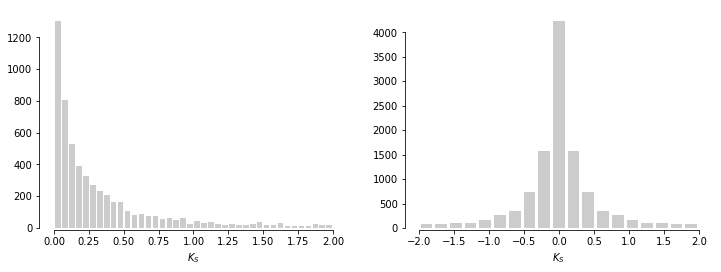

In [3]:
ks = np.array(df['Ks'])
ks = ks[ks > 0.005]
ks = list(ks[ks < 2])
ks_reflected = ks + list(-1*np.array(ks))
ks = np.array(ks)

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(ks, bins=40, rwidth=0.8, color='k', alpha=0.2)
axes[0].set_xlabel("$K_S$")
ax = axes[1].hist(ks_reflected, bins=19, rwidth=0.8, color='k', alpha=0.2)
axes[1].set_xlabel("$K_S$")
sns.despine(trim=True, offset=2)

In [4]:
def kde(ks, ax):
    """
    Function for fitting and plotting a KDE with and without reflection.
    Uses the default bandwidth selection (i.e. Scott's rule).
    """
    ks_reflected = list(ks) + list(-1*np.array(ks))
    
    ax1 = sns.distplot(
        ks, ax = ax, bins=50, 
        hist_kws={"rwidth": 0.8, "color": "k", "alpha": 0}, 
        color="k", label="Boundary"
    )
    ax.vlines(x=np.median(ks), ymax=6, ymin=0, linestyles="--", alpha=0.9)
    ax.set_xlim(0, 2)
    ax.set_xlabel("$K_{\mathrm{S}}$")
    ax.set_ylabel("density")

    ax2 = ax1.twinx()
    ax = sns.distplot(
        ks_reflected, bins=100, ax = ax2, 
        hist_kws={"rwidth": 0.8, "color": "k", "alpha": 0.2}, 
        color="forestgreen", label="Reflected"
    )
    ax.set_xlim(0, 2)
    ax.set_yticks([])


    #Create custom artists
    simArtist = plt.Line2D((0,1),(0,0), color='k')
    anyArtist = plt.Line2D((0,1),(0,0), color='forestgreen')

    #Create legend from custom artist/label lists
    ax.legend([simArtist,anyArtist], ['Boundary', 'Reflected'], frameon=False)
    sns.despine(offset=5, trim=True)
    return ax

/home/arzwa/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


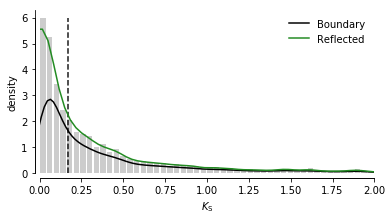

In [5]:
fig, ax = plt.subplots(figsize=(6,3))
ax = kde(ks, ax);
#fig.savefig("./img/smo.kde.pdf", bbox_inches='tight')

**Note**: this warning is due to changes made in matplotlib which have not yet been dealed with in seaborn.

**Note**: `kdeplot` and `distplot` from `seaborn`, as well as `gaussian_kde` from `scipy.stats`, use Scott's method to determine a 'rule of thumb' bandwidth parameter. One could play with this bandwidth parameter to see more or less fine structure in the data, but my experience is that it works quite well for $K_S$ distributions. If necessary, use a smaller bandwidth (which will result in a more noisy density) and let your eye do the necessary smoothing (see for example rightmost plot in the above figure).

**Note**: The y-axis is a density not a probability. It reflects a probability per unit of measurement. So if you for example would get a density of 2 on the interval 0.6 to 0.5, this would amount to approximately a probability of $2 [\frac{1}{K_S}] \times ( 0.6 - 0.5 ) [K_S] = 0.2$ for a $K_S$ measurement to fall in this interval

### Gaussian mixture modeling

In the cell below, some functions for Gaussian mixture modeling are provided.

In [6]:
import scipy.stats as ss
from sklearn import mixture


def gmm(X, n, **kwargs):
    """
    Compute Gaussian mixtures for different numbers of components
    """
    # fit models with 1 to n components
    N = np.arange(1, n + 1)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = mixture.GaussianMixture(
            n_components=N[i], covariance_type='full', max_iter=100, **kwargs
        ).fit(X)

    # compute the AIC and the BIC
    aic = [m.aic(X) for m in models]
    bic = [m.bic(X) for m in models]
    best = models[np.argmin(bic)]
    
    return models, bic, aic, best


def plot_mixture(model, data, ax, l=0.1, u=5, color='black', alpha=0.2, 
                 log=False, bins=25, alpha_l1=1):
    """
    Plot a mixture model. Assumes a log-transformed model and data
    and will back-transform.
    
    Note from scipy docs: 
    ---------------------
    A common parametrization for a lognormal random variable Y 
    is in terms of the mean, mu, and standard deviation, sigma, 
    of the unique normally distributed random variable X such 
    that exp(X) = Y. This parametrization corresponds to setting 
    s = sigma and scale = exp(mu).
    
    So since we fit a normal mixture on the logscale, we can get
    the lognormal by setting scale to np.exp(mean[k]) and s to 
    np.sqrt(variance[k]) for component k.
    """
    x = np.linspace(l, u, 1000).reshape((-1, 1))
    if not log:
        data = np.exp(data)
    data = data[data >= l]
    data = data[data <= u]
    bins = ax.hist(data, bins, rwidth=0.8, color=color, alpha=alpha, density=True)
    maxy = max(bins[0])
    means = model.means_
    varcs = model.covariances_
    weights = model.weights_
    mix = None
    first = True
    for k in range(len(means)):
        if not log:
            curve = ss.lognorm.pdf(x, scale=np.exp(means[k]), s=np.sqrt(varcs[k])) * weights[k]
        else:
            curve = ss.norm.pdf(x, loc=means[k], scale=np.sqrt(varcs[k])) * weights[k]
        ax.plot(x, curve, '--k', color='black', alpha=0.4)
        if first:
            mix = curve
            first = False
        else:
            mix += curve
    ax.plot(x, mix, color='black', alpha=alpha_l1)
    return ax


def inspect_aic(aic):
    """
    Evaluate the information criterion results for mixture models.
    """
    im = np.argmin(aic) 
    print("min(AIC) = {:.2f} for model {}".format(aic[im], im+1))
    print("Relative probabilities compared to model {}:".format(im+1))
    print("   /                          \\")
    print("   |      (min(AIC) - AICi)/2 |")
    print("   | p = e                    |")
    print("   \                          /")
    for i, aic_i in enumerate(aic):
        p_i = np.exp((aic[im] - aic_i)/2)
        print(". model{:>4}: p = {:.4f}".format(i+1, p_i))
    print()
        
        
def inspect_bic(bic):
    im = np.argmin(bic)
    l = [
        "0 to  2:   Very weak",
        "2 to  6:    Positive",
        "6 to 10:      Strong",
        "    >10: Very Strong"
    ]
    print("Delta BIC assessment: ")
    print("min(BIC) = {:.2f}".format(bic[im]))
    for i, bic_i in enumerate(bic):
        dbic = bic_i - bic[im]
        j = 0
        if dbic > 2: j = 1
        if dbic > 6: j = 2
        if dbic > 10: j = 3
        print(". model{:>4}: delta(BIC) = {:>8.2f} ({})".format(i+1, dbic, l[j]))
    print()
        
        
def plot_probs(m, ax, l=0.01, u=5, ylab=True):
    """
    Plot posterior component probabilities
    """
    x = np.linspace(l, u, 1000).reshape(-1, 1)
    p = m.predict_proba(np.log(x))
    p = p.cumsum(1).T
    x = np.linspace(l, u, 1000)
    order = tuple(np.argsort(m.means_.reshape((1, -1)))[0])
    alphas = np.linspace(0.2, 1, p.shape[0])[order,]
    for i, array in enumerate(p):
        if i == 0:
            ax.fill_between(x, 0, p[i], color='gray', alpha=alphas[i], label=str(i+1))
        elif i == len(alphas) - 1:
            ax.fill_between(x, p[i-1], 1, color='gray', alpha=alphas[i], label=str(i+1))
        else:
            ax.fill_between(x, p[i-1], p[i], color='gray', alpha=alphas[i], label=str(i+1))
    ax.set_xlim(l, u)
    ax.set_ylim(0, 1)
    ax.set_xlabel('$K_S$')
    if ylab:
        ax.set_ylabel('$P(class|K_S)$')
    ax.legend(frameon=True)
    return ax


def plot_aic(aic, ax):
    ax.plot(np.arange(1,len(aic)+1), aic, color='k', marker='o')
    ax.set_xticks(list(range(1,len(aic)+1)))
    ax.grid(ls=":")
    return ax

In [7]:
# read and filter the data
df = pd.read_csv('data/cds.smo.fasta.ks.tsv', sep='\t', index_col=0)
df = df[df["AlignmentLengthStripped"] >= 300]
df = df.groupby(['Family', 'Node']).mean()
df = df[df['Ks'] > 0.005]
df = df[df['Ks'] < 2]
log_ks = np.log(df["Ks"].dropna()).values.reshape((-1,1))

Text(0.5,0,'$ln(K_S)$')

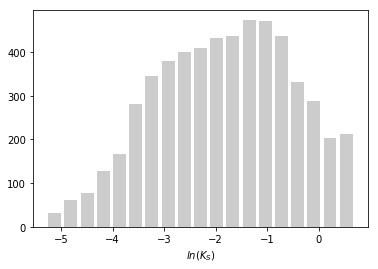

In [8]:
plt.hist(log_ks, bins=19, rwidth=0.8, color='k', alpha=0.2);
plt.xlabel("$ln(K_S)$")

This is what a $ln(K_S)$ distribution looks like in the absence of WGD.

In [9]:
models, bic, aic, best = gmm(log_ks, 8)
models_n, bic_n, aic_n, best_n = gmm(np.exp(log_ks), 8)

In [14]:
print(best.means_)

[[-2.00238908]
 [-4.07900448]
 [-0.00693621]
 [-3.02843363]
 [-1.03539049]]


In [10]:
inspect_aic(aic)
inspect_bic(bic)

min(AIC) = 18435.78 for model 8
Relative probabilities compared to model 8:
   /                          \
   |      (min(AIC) - AICi)/2 |
   | p = e                    |
   \                          /
. model   1: p = 0.0000
. model   2: p = 0.0000
. model   3: p = 0.0000
. model   4: p = 0.0000
. model   5: p = 0.0000
. model   6: p = 0.0000
. model   7: p = 0.0000
. model   8: p = 1.0000

Delta BIC assessment: 
min(BIC) = 18583.64
. model   1: delta(BIC) =   271.88 (    >10: Very Strong)
. model   2: delta(BIC) =    45.74 (    >10: Very Strong)
. model   3: delta(BIC) =    51.37 (    >10: Very Strong)
. model   4: delta(BIC) =    21.06 (    >10: Very Strong)
. model   5: delta(BIC) =     0.00 (0 to  2:   Very weak)
. model   6: delta(BIC) =    13.03 (    >10: Very Strong)
. model   7: delta(BIC) =    27.51 (    >10: Very Strong)
. model   8: delta(BIC) =     4.46 (2 to  6:    Positive)



In [11]:
inspect_aic(aic_n)
inspect_bic(bic_n)

min(AIC) = -1666.45 for model 8
Relative probabilities compared to model 8:
   /                          \
   |      (min(AIC) - AICi)/2 |
   | p = e                    |
   \                          /
. model   1: p = 0.0000
. model   2: p = 0.0000
. model   3: p = 0.0000
. model   4: p = 0.0000
. model   5: p = 0.0000
. model   6: p = 0.0000
. model   7: p = 0.0000
. model   8: p = 1.0000

Delta BIC assessment: 
min(BIC) = -1514.14
. model   1: delta(BIC) =  7377.01 (    >10: Very Strong)
. model   2: delta(BIC) =  2316.96 (    >10: Very Strong)
. model   3: delta(BIC) =   597.46 (    >10: Very Strong)
. model   4: delta(BIC) =   389.43 (    >10: Very Strong)
. model   5: delta(BIC) =   360.38 (    >10: Very Strong)
. model   6: delta(BIC) =   158.68 (    >10: Very Strong)
. model   7: delta(BIC) =   116.38 (    >10: Very Strong)
. model   8: delta(BIC) =     0.00 (0 to  2:   Very weak)



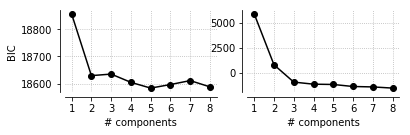

In [12]:
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])

#gs.update(left=0.01, right=0.6, hspace=0.2, bottom=0.3)
fig = plt.figure(figsize=(6,1.5))
ax = plt.subplot(gs[0])
ax = plot_aic(bic, ax)
ax.set_ylabel("BIC")
ax.set_xlabel("# components")
ax = plt.subplot(gs[1])
ax = plot_aic(bic_n, ax)
ax.set_xlabel("# components")
sns.despine(offset=5)

#fig.savefig("./img/smo.gmms_bic.pdf", bbox_inches='tight')
#fig.tight_layout()

There is clearly overfitting, more components are always better! This holds for Normals and log-normals. However $\Delta AIC$ is way larger for the Normal components. In the log-normal case, 1 component already provides a good fit compared to having more components, and this is definitely not the case when fitting Normals!

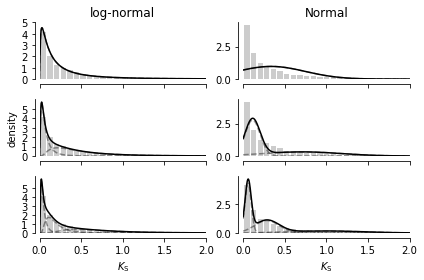

In [13]:
from matplotlib import gridspec
fig, axes = plt.subplots(3, 2, figsize=(6,4))

j = 0
for i in range(3):
    m = models[i]
    ax = axes[i, 0]
    ax = plot_mixture(m, log_ks, ax, l=0, u=2)
    ax.set_xlim(0,2)
    ax.set_yticks(list(range(6)))
    if i == 0: ax.set_title("log-normal")
    if i == 1: ax.set_ylabel("density")
    j += 1
    if i != 2: ax.set_xticklabels([])
    else: ax.set_xlabel('$K_{\mathrm{S}}$')
    
    m = models_n[i]
    ax = axes[i, 1]
    ax = plot_mixture(m, np.exp(log_ks), ax, l=0, u=2, log=True, alpha_l1=1)
    ax.set_xlim(0,2)
    if i == 0: ax.set_title("Normal")
    if i != 2: ax.set_xticklabels([])
    else: ax.set_xlabel('$K_{\mathrm{S}}$')
    j+=1
sns.despine( offset=5)

#fig.savefig("./img/smo.gmms_mixtures.pdf", bbox_inches='tight')
fig.tight_layout()

One log-normal component gives a very good visual fit, which is in the Normal case only achieved starting from the three component model. 

## *Solanum lycopersicum*

The Solanaceae hexploidy event is a well described WGM (M for multiplication) event. *S. lycopersicum* is here used to 
show how a WGD peak can consist of a significant fraction of SSDs. These can not not be distinguished using $K_S$ or reconciliation based methods (positional information provides help here).

### GMMs

In [3]:
df = pd.read_csv('data/cds.sly.csv.ks.tsv', sep='\t', index_col=0)
df = df[df["AlignmentLengthStripped"] >= 300]
df = df.groupby(['Family', 'Node']).mean()
df = df[df['Ks'] > 0.005]
df = df[df['Ks'] < 2]
log_ks = np.log(df["Ks"].dropna()).values.reshape((-1,1))

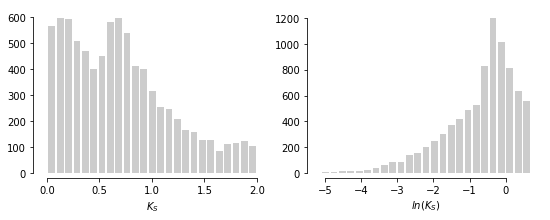

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))
axes[0].hist(np.exp(log_ks), bins=25, rwidth=0.8, color='k', alpha=0.2);
axes[0].set_xlabel("$K_S$")
axes[1].hist(log_ks, bins=25, rwidth=0.8, color='k', alpha=0.2);
axes[1].set_xlabel("$ln(K_S)$")
sns.despine(trim=True, offset=5)

In [10]:
models, bic, aic, best = gmm(log_ks, 8)
models_n, bic_n, aic_n, best_n = gmm(np.exp(log_ks), 8)

In [11]:
inspect_aic(aic)
inspect_bic(bic)

min(AIC) = 20577.45 for model 8
Relative probabilities compared to model 8:
   /                          \
   |      (min(AIC) - AICi)/2 |
   | p = e                    |
   \                          /
. model   1: p = 0.0000
. model   2: p = 0.0000
. model   3: p = 0.0000
. model   4: p = 0.0000
. model   5: p = 0.0000
. model   6: p = 0.0000
. model   7: p = 0.0000
. model   8: p = 1.0000

Delta BIC assessment: 
min(BIC) = 20738.82
. model   1: delta(BIC) =  2468.63 (    >10: Very Strong)
. model   2: delta(BIC) =   353.62 (    >10: Very Strong)
. model   3: delta(BIC) =   205.29 (    >10: Very Strong)
. model   4: delta(BIC) =   134.76 (    >10: Very Strong)
. model   5: delta(BIC) =    49.30 (    >10: Very Strong)
. model   6: delta(BIC) =    49.84 (    >10: Very Strong)
. model   7: delta(BIC) =    37.70 (    >10: Very Strong)
. model   8: delta(BIC) =     0.00 (0 to  2:   Very weak)



In [12]:
inspect_aic(aic_n)
inspect_bic(bic_n)

min(AIC) = 8890.84 for model 8
Relative probabilities compared to model 8:
   /                          \
   |      (min(AIC) - AICi)/2 |
   | p = e                    |
   \                          /
. model   1: p = 0.0000
. model   2: p = 0.0000
. model   3: p = 0.0000
. model   4: p = 0.0000
. model   5: p = 0.0000
. model   6: p = 0.0000
. model   7: p = 0.0000
. model   8: p = 1.0000

Delta BIC assessment: 
min(BIC) = 9052.21
. model   1: delta(BIC) =  2486.87 (    >10: Very Strong)
. model   2: delta(BIC) =  1384.78 (    >10: Very Strong)
. model   3: delta(BIC) =   367.29 (    >10: Very Strong)
. model   4: delta(BIC) =   319.73 (    >10: Very Strong)
. model   5: delta(BIC) =   253.83 (    >10: Very Strong)
. model   6: delta(BIC) =   107.69 (    >10: Very Strong)
. model   7: delta(BIC) =    41.27 (    >10: Very Strong)
. model   8: delta(BIC) =     0.00 (0 to  2:   Very weak)



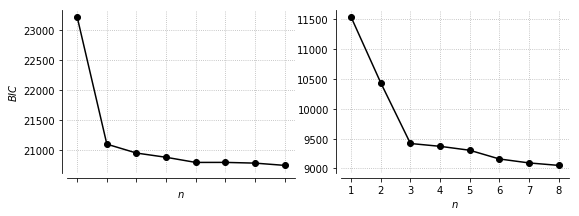

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].plot(np.arange(1,9), bic, color='k', marker='o')
axes[0].set_xticklabels([])
axes[0].set_xticks(list(range(1,9)))
axes[0].grid(ls=":")
axes[0].set_xlabel('$n$')
axes[0].set_ylabel('$BIC$')
axes[1].plot(np.arange(1,9), bic_n, color='k', marker='o')
axes[1].set_xlabel('$n$')
axes[1].set_xticks(list(range(1,9)))
axes[1].grid(ls=":")
sns.despine(offset=5)

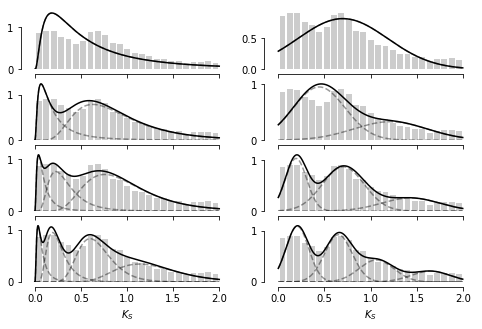

In [92]:
fig, axes = plt.subplots(4, 2, figsize=(8, 5))
for i in range(4):
    m = models[i]
    ax = plot_mixture(m, log_ks, axes[i, 0], l=0, u=2)
    ax.set_xlabel('$K_S$')
    m = models_n[i]
    ax = plot_mixture(m, np.exp(log_ks), axes[i, 1], l=0, u=2, log=True)
    ax.set_xlabel('$K_S$')
sns.despine(trim=True, offset=5)

Again the log-normals make way more sense for smaller (realistic) numbers of components. Note that the three component model gives a very satisfying visual fit, but the first peak is of unknown origin. Inspecting these distributions on a log scale is also nice.

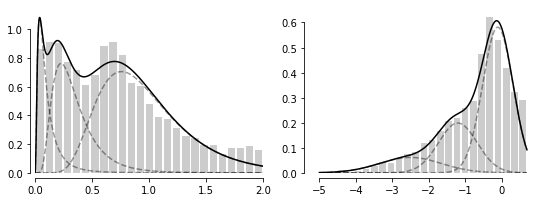

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))
ax = plot_mixture(models[2], log_ks, axes[0], l=0, u=2, bins=25)
ax.set_xlim(0,2)
ax = plot_mixture(models[2], log_ks, axes[1], l=-5, u=np.log(2), bins=25, log=True)
#ax.set_xlim(0,2)
sns.despine(trim=True, offset=5)

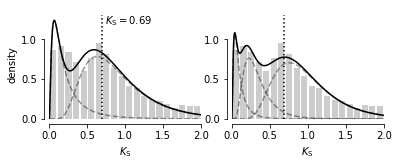

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(6,2))
ax = plot_mixture(models[1], log_ks, axes[0], l=0, u=2, bins=20)
ax.set_xlim(0,2)
l, u = ax.get_ylim()
ax.set_ylabel("density")
ax.vlines(x=0.69, ymin=l, ymax=u, linestyles=":")
ax.text(s="$K_{\mathrm{S}} = 0.69$", x=0.74, y=u - 0.1)
ax.set_xlabel("$K_{\mathrm{S}}$")
sns.despine(trim=True, offset=5, ax=ax)
ax = plot_mixture(models[2], log_ks, axes[1], l=0, u=2, bins=20)
ax.vlines(x=0.69, ymin=l, ymax=u, linestyles=":")
ax.set_xlim(0,2)
ax.set_xlabel("$K_{\mathrm{S}}$")
sns.despine(trim=True, offset=5, ax=ax)
#fig.savefig('img/sly.gmm_1.pdf', bbox_inches="tight")

Now let's make those posterior component probability plots. Inspired by: http://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html

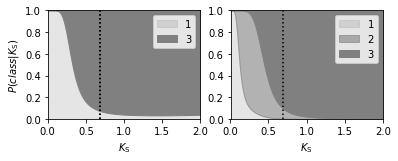

In [186]:
fig, axes = plt.subplots(1, 2, figsize=(6,2))
ax =axes[0]
m = models[1]
l, u = (0.005, 2)
x = np.linspace(l, u, 1000).reshape(-1, 1)
p = m.predict_proba(np.log(x))
p = p[:, (1, 0)]
p = p.cumsum(1).T
x = np.linspace(l, u, 1000)
ax.fill_between(x, 0, p[0], color='gray', alpha=0.2, label="1")

ax.fill_between(x, p[0], 1, color='gray', alpha=1, label="3")
ax.vlines(x=0.69, ymin=0, ymax=1, linestyles=':')
ax.set_xlim(l, u)
ax.set_ylim(0, 1)
ax.set_xlabel('$K_{\mathrm{S}}$')
ax.set_ylabel('$P(class|K_{\mathrm{S}})$')
ax.legend(frameon=True)
ax.vlines(x=0.69, ymin=0, ymax=1, linestyles=":")

ax =axes[1]
m = models[2]
l, u = (0.005, 2)
x = np.linspace(l, u, 1000).reshape(-1, 1)
p = m.predict_proba(np.log(x))
p = p[:, (2, 0, 1)]
p = p.cumsum(1).T
x = np.linspace(l, u, 1000)
ax.fill_between(x, 0, p[0], color='gray', alpha=0.2, label="1")
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.6, label="2")
ax.fill_between(x, p[1], 1, color='gray', alpha=1, label="3")
ax.vlines(x=0.69, ymin=0, ymax=1, linestyles=':')
ax.set_xlim(l, u)
ax.set_ylim(0, 1)
ax.set_xlabel('$K_{\mathrm{S}}$')
ax.legend(frameon=True)
#fig.savefig('img/sly.gmm_b.pdf', bbox_inches="tight")

Note that the labels for the different components may be switched with different runs.

## *Glycine max*

*G. max* is a very good example of a recent WGD, with a whole load of retained duplicates!

### GMMs

In [15]:
df = pd.read_csv('data/cds.gma.csv.ks.tsv', sep='\t', index_col=0)
df = df[df["AlignmentLengthStripped"] >= 300]
df = df.groupby(['Family', 'Node']).mean()
df = df[df['Ks'] > 0.005]
df = df[df['Ks'] < 5]
log_ks = np.log(df["Ks"].dropna()).values.reshape((-1,1))

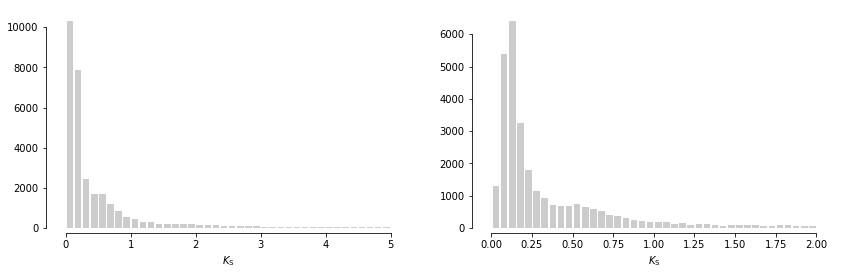

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].hist(np.exp(log_ks), bins=40, rwidth=0.8, color='k', alpha=0.2);
axes[0].set_xlabel("$K_{\mathrm{S}}$")
df = df[df['Ks'] < 2]
log_ks = np.log(df["Ks"].dropna()).values.reshape((-1,1))
axes[1].hist(np.exp(log_ks), bins=40, rwidth=0.8, color='k', alpha=0.2);
axes[1].set_xlabel("$K_{\mathrm{S}}$")
sns.despine(trim=True, offset=5)
fig.savefig('img/gly_hist.pdf')

In [189]:
models, bic, aic, best = gmm(log_ks, 8)
models_n, bic_n, aic_n, best_n = gmm(np.exp(log_ks), 8)

In [190]:
inspect_aic(aic)
inspect_bic(bic)

min(AIC) = 73676.11 for model 7
Relative probabilities compared to model 7:
   /                          \
   |      (min(AIC) - AICi)/2 |
   | p = e                    |
   \                          /
. model   1: p = 0.0000
. model   2: p = 0.0000
. model   3: p = 0.0000
. model   4: p = 0.0000
. model   5: p = 0.0000
. model   6: p = 0.0000
. model   7: p = 1.0000
. model   8: p = 0.0929

Delta BIC assessment: 
min(BIC) = 73841.33
. model   1: delta(BIC) =  5331.78 (    >10: Very Strong)
. model   2: delta(BIC) =  3391.83 (    >10: Very Strong)
. model   3: delta(BIC) =   395.80 (    >10: Very Strong)
. model   4: delta(BIC) =   278.65 (    >10: Very Strong)
. model   5: delta(BIC) =   162.39 (    >10: Very Strong)
. model   6: delta(BIC) =    50.12 (    >10: Very Strong)
. model   7: delta(BIC) =     0.00 (0 to  2:   Very weak)
. model   8: delta(BIC) =    29.53 (    >10: Very Strong)



In [191]:
inspect_aic(aic_n)
inspect_bic(bic_n)

min(AIC) = -15749.72 for model 8
Relative probabilities compared to model 8:
   /                          \
   |      (min(AIC) - AICi)/2 |
   | p = e                    |
   \                          /
. model   1: p = 0.0000
. model   2: p = 0.0000
. model   3: p = 0.0000
. model   4: p = 0.0000
. model   5: p = 0.0000
. model   6: p = 0.0000
. model   7: p = 0.0000
. model   8: p = 1.0000

Delta BIC assessment: 
min(BIC) = -15559.72
. model   1: delta(BIC) = 40315.12 (    >10: Very Strong)
. model   2: delta(BIC) =  5495.78 (    >10: Very Strong)
. model   3: delta(BIC) =  1513.10 (    >10: Very Strong)
. model   4: delta(BIC) =  1083.06 (    >10: Very Strong)
. model   5: delta(BIC) =   416.46 (    >10: Very Strong)
. model   6: delta(BIC) =    59.10 (    >10: Very Strong)
. model   7: delta(BIC) =    25.81 (    >10: Very Strong)
. model   8: delta(BIC) =     0.00 (0 to  2:   Very weak)



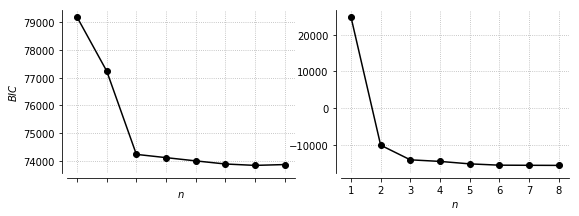

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].plot(np.arange(1,9), bic, color='k', marker='o')
axes[0].set_xticklabels([])
axes[0].set_xticks(list(range(1,9)))
axes[0].grid(ls=":")
axes[0].set_xlabel('$n$')
axes[0].set_ylabel('$BIC$')
axes[1].plot(np.arange(1,9), bic_n, color='k', marker='o')
axes[1].set_xlabel('$n$')
axes[1].set_xticks(list(range(1,9)))
axes[1].grid(ls=":")
sns.despine(offset=5)

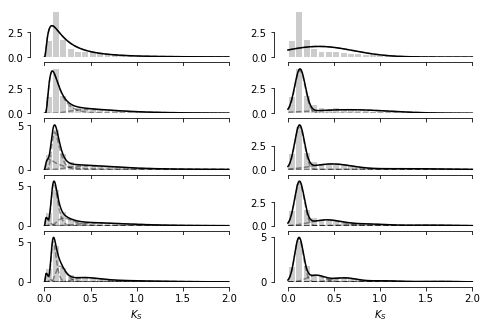

In [193]:
fig, axes = plt.subplots(5, 2, figsize=(8, 5))
for i in range(5):
    m = models[i]
    ax = plot_mixture(m, log_ks, axes[i, 0], l=0, u=2)
    ax.set_xlabel('$K_S$')
    m = models_n[i]
    ax = plot_mixture(m, np.exp(log_ks), axes[i, 1], l=0, u=2, log=True)
    ax.set_xlabel('$K_S$')
sns.despine(trim=True, offset=5)

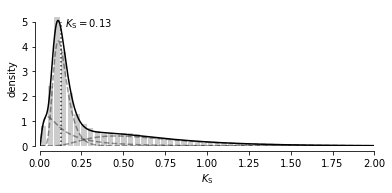

In [196]:
fig, ax = plt.subplots(figsize=(6, 2.5))
ax = plot_mixture(models[2], log_ks, ax, l=0, u=2, bins=50)
ax.set_xlim(0,2)
ax.set_ylabel("density")
ax.vlines(x=0.13, ymin=0, ymax=5.0, linestyles=':', alpha=0.8)
sns.despine(trim=True, offset=5)
ax.set_xlabel("$K_{\mathrm{S}}$")
ax.text(s="$K_{\mathrm{S}} = 0.13$", x=0.15, y=4.8);
#fig.savefig("img/gma.gmm.pdf", bbox_inches='tight')

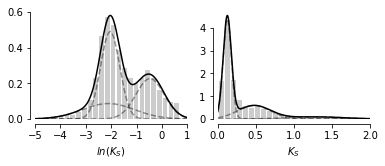

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(6,2))
ax = plot_mixture(models[2], log_ks, axes[0], l=-5, u=1, bins=25, log=True)
ax.set_xlim(-5,1)
ax.set_xticks([-5, -4, -3, -2, -1, 0, 1])
ax.set_xlabel("$ln(K_S)$")
ax = plot_mixture(models_n[2], np.exp(log_ks), axes[1], l=0, u=2, bins=25, log=True)
ax.set_xlim(0,2)
ax.set_xlabel("$K_S$")
sns.despine(trim=True, offset=5)
#fig.savefig("img/gma.gmm_n.pdf", bbox_inches='tight')

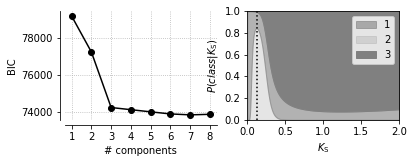

In [207]:
m = models[2]
l, u  = (0.005, 2)

fig, axes = plt.subplots(1, 2, figsize=(6, 2))

ax = axes[0]
ax = plot_aic(bic, ax)
ax.set_ylabel("BIC")
ax.set_xlabel("# components")
sns.despine(ax=ax, offset=5)

ax = axes[1]
x = np.linspace(l, u, 1000).reshape(-1, 1)
p = m.predict_proba(np.log(x))
p = p[:, (2, 0, 1)]
p = p.cumsum(1).T
x = np.linspace(l, u, 1000)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.6, label="1")
ax.fill_between(x, 0, p[0], color='gray', alpha=0.2, label="2")
ax.fill_between(x, p[1], 1, color='gray', alpha=1, label="3")
ax.vlines(x=0.13, ymin=0, ymax=1, linestyles=':')

ax.set_xlim(l, u)
ax.set_ylim(0, 1)
ax.set_xlabel('$K_{\mathrm{S}}$')
ax.set_ylabel('$P(class|K_{\mathrm{S}})$')
ax.legend(frameon=True)
#fig.savefig("img/gma.gmm_aic.pdf", bbox_inches='tight')